In [1]:
import polars as pl
import numpy as np
import pickle
from typing import List
from itertools import chain, combinations
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
import statsmodels.api as sm
from statsmodels.genmod.generalized_linear_model import GLMResults
from statsmodels.genmod.families import family

In [3]:
import graphviz
import networkx as nx
from cdt.data import AcyclicGraphGenerator
import scipy

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


In [4]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from collections import OrderedDict

In [5]:
class TestingRound:
    iterations = 0
    last_deviance = None
    deviance = 0
    convergence_threshold = 1e-8
    rss = None
    llf = None
    total_samples = None
    
    def __init__(self, y_label, X_labels):
        self.y_label = y_label
        self.X_labels = X_labels
        self._init_beta0()
        self.client_data = {
            'xtx': [],
            'xtz': [],
            'dev': [],
            'llf': [],
            'rss': [],
            'nobs': []
            }
        
    def __eq__(self, t):
        assert type(t) == TestingRound
        return self.y_label == t.y_label and self.X_labels == t.X_labels   
    
    def __repr__(self):
        return f'TestingRound - y: {self.y_label}, X: {self.X_labels}, total samples: {self.total_samples}, beta: {self.beta}, current iteration: {self.iterations}, current deviance: {abs(self.deviance)}, relative deviance change: {abs(self.deviance - self.last_deviance) / (0.1 + abs(self.deviance)) if self.last_deviance is not None else "?"}, llf: {self.llf}, rss: {self.rss}' 
    
    def _init_beta0(self):
        #self.beta = np.random.randn(len(self.X_labels) + 1) # +1 for intercept
        self.beta = np.zeros(len(self.X_labels) + 1) # +1 for intercept
        
    def get_relative_change_in_deviance(self):
        if self.last_deviance is None:
            return None
        return abs(self.deviance - self.last_deviance) / (0.1 + abs(self.deviance))
    
    def get_fit_stats(self, client_subset=None):
        #dev = [v for k,v in self.client_data['dev'].items() if client_subset is None or k in client_subset]
        llf = [v for k,v in self.client_data['llf'].items() if client_subset is None or k in client_subset]
        rss = [v for k,v in self.client_data['rss'].items() if client_subset is None or k in client_subset]
        nobs = [v for k,v in self.client_data['nobs'].items() if client_subset is None or k in client_subset]
    
        return {'llf': sum(llf), 'rss': sum(rss), 'nobs': sum(nobs)}
        
    def aggregate_results(self, results):
        self.providing_clients = set(results.keys())
        
        client_data = [[(k,vi) for vi in v] for k,v in results.items()]
        xtx, xtz, dev, llf, rss, nobs = zip(*client_data)
        xtx, xtz, dev, llf, rss, nobs = dict(xtx), dict(xtz), dict(dev), dict(llf), dict(rss), dict(nobs)
        
        self.client_data['xtx'] = xtx
        self.client_data['xtz'] = xtz
        self.client_data['dev'] = dev
        self.client_data['llf'] = llf
        self.client_data['rss'] = rss
        self.client_data['nobs'] = nobs
        
        self.beta = np.linalg.inv(sum(xtx.values())) @ sum(xtz.values())
        self.last_deviance = self.deviance
        self.deviance = sum(dev.values())
        self.llf = sum(llf.values())
        self.rss = sum(rss.values())
        self.total_samples = sum(nobs.values())
        self.iterations += 1
        
        return self.get_relative_change_in_deviance() < self.convergence_threshold
    
class TestingEngine:
    testing_rounds = []
    finished_rounds = []
    
    def __init__(self, available_data, max_regressors=None, max_iterations=25, save_steps=10):
        self.available_data = available_data
        self.max_regressors = max_regressors
        self.max_iterations = max_iterations
        self.save_steps = save_steps
        
        _max_conditioning_set_size = min(len(self.available_data)-1, self.max_regressors) if self.max_regressors is not None else len(self.available_data)-1
        
        for y_var in available_data:
            set_of_regressors = available_data - {y_var}
            powerset_of_regressors = chain.from_iterable(combinations(set_of_regressors, r) for r in range(0,_max_conditioning_set_size+1))
            self.testing_rounds.extend([TestingRound(y_label=y_var, X_labels=sorted(list(x_vars))) for x_vars in powerset_of_regressors])
            
        self.testing_rounds = sorted(self.testing_rounds, key=lambda key: len(key.X_labels))
        self.is_finished = len(self.testing_rounds) == 0
            
    def get_current_test_parameters(self):
        curr_testing_round = self.testing_rounds[0]
        return curr_testing_round.y_label, curr_testing_round.X_labels, curr_testing_round.beta
    
    def remove_current_test(self):
        self.testing_rounds.pop(0)
        self.is_finished = len(self.testing_rounds) == 0
    
    def finish_current_test(self):
        self.finished_rounds.append(self.testing_rounds.pop(0))
        self.is_finished = len(self.testing_rounds) == 0
        
    def aggregate_results(self, results):
        has_converged = self.testing_rounds[0].aggregate_results(results)
        has_reached_max_iterations = self.testing_rounds[0].iterations >= self.max_iterations
        if has_converged or has_reached_max_iterations:
            self.finish_current_test()
        

class Server:
    clients = {}
    
    def __init__(self, clients, max_regressors=None):
        self.clients = clients
        self.available_data = set.union(*[set(c.data_labels) for c in self.clients.values()])
        self.testing_engine = TestingEngine(self.available_data, max_regressors=max_regressors)
        
    def run_tests(self):
        counter = 1
        while not self.testing_engine.is_finished:
            y_label, X_labels, beta = self.testing_engine.get_current_test_parameters()
            selected_clients = {id_: c for id_, c in self.clients.items() if set([y_label] + X_labels).issubset(c.data_labels)}
            if len(selected_clients) == 0:
                self.testing_engine.remove_current_test()
                continue
            # http response, to compute glm results for y regressed on X with beta
            results = {id:c.compute(y_label, X_labels, beta) for id_,c in selected_clients.items()}
            self.testing_engine.aggregate_results(results)
            if counter % self.testing_engine.save_steps == 0:
                counter = 0
                with open('./testengine.ckp', 'wb') as f:
                    pickle.dump(self.testing_engine, f)
            counter += 1
                
    
class Client:
    def __init__(self, data):
        self.data = data
        self.data_labels = data.columns
        
        
    def compute(self, y_label: str, X_labels: List[str], beta):
        y = self.data[y_label]
        X = self.data[X_labels]
        
        X = X.to_numpy()
        X = sm.tools.add_constant(X)
                
        eta, mu, dmu_deta, deviance, llf, rss = self._init_compute(y,X,beta)
        
        z = eta + (y - mu)/dmu_deta
        W = np.diag((dmu_deta**2)/max(np.var(mu), 1e-8))
        
        r1 = X.T @ W @ X
        r2 = X.T @ W @ z
        
        return r1, r2, deviance, llf, rss, len(y)
        
        
    def _init_compute(self, y, X, beta):
        glm_model = sm.GLM(y, X, family=family.Gaussian())
        normalized_cov_params = np.linalg.inv(X.T.dot(X))
        scale = glm_model.fit().scale
        glm_results = GLMResults(glm_model, beta, normalized_cov_params=normalized_cov_params, scale=None)
        
        # GLMResult with correct scale
        #scale = glm_model.estimate_scale(glm_results.predict(which='linear'))
        #glm_results = GLMResults(glm_model, beta, normalized_cov_params=normalized_cov_params, scale=scale)
        
        eta = glm_results.predict(which='linear')
        
        # g' is inverse of link function
        inverse_link = glm_results.family.link.inverse
        mu = inverse_link(eta)
        
        deviance = glm_results.deviance
        
        # delta g' is derivative of inverse link function
        derivative_inverse_link = glm_results.family.link.inverse_deriv
        dmu_deta = derivative_inverse_link(eta)
        return eta, mu, dmu_deta, deviance, glm_results.llf, sum((eta-y)**2)
    

In [6]:
class LikelihoodRatioTest:
    def __init__(self, t0: TestingRound, t1: TestingRound) -> None:
        
        assert t0.y_label == t1.y_label
        self.t0 = t0
        self.t1 = t1
        
        if len(t0.X_labels) == 0 and len(t1.X_labels) == 1:
            self.y_label = self.t0.y_label
            self.x_label = self.t1.X_labels[0]
            self.s_labels = []
        else:
            assert len(t0.X_labels) == 1
            assert len(t1.X_labels) > 1
            assert t0.X_labels[0] in t1.X_labels
            
            self.y_label = self.t0.y_label
            self.x_label = self.t0.X_labels[0] if len(t0.X_labels) > 0 else None
            self.s_labels = sorted(list(set(self.t1.X_labels) - {self.x_label})) if t1 is not None else []
        
        #self.p_val = self._run_f_test()
        self.p_val = self._run_likelihood_test()
        
    def __repr__(self):
        return f"LikelihoodRatioTest - y: {self.y_label}, x: {self.x_label}, S: {self.s_labels}, p: {self.p_val}"
    
    def _run_likelihood_test(self):
        
        # t1 should always encompass more regressors -> less client can fulfill this
        #assert len(self.t1.providing_clients) < len(self.t0.providing_clients)
        
        t0_fit_stats = self.t0.get_fit_stats(self.t1.providing_clients)
        t1_fit_stats = self.t1.get_fit_stats(self.t1.providing_clients)
        
        #assert t0_fit_stats['nobs'] == t1_fit_stats['nobs']
        
        t = -2*(t0_fit_stats['llf'] - t1_fit_stats['llf'])
        
        par0 = len(self.t0.X_labels) + 1 # + intercept
        par1 = len(self.t1.X_labels) + 1 # + intercept
        
        p_val = scipy.stats.chi2.sf(t, par1-par0)
        
        return p_val
        
    def _run_f_test(self):
        # t1 should always encompass more regressors -> less client can fulfill this
        #assert len(self.t1.providing_clients) < len(self.t0.providing_clients)
        
        t0_fit_stats = self.t0.get_fit_stats(self.t1.providing_clients)
        t1_fit_stats = self.t1.get_fit_stats(self.t1.providing_clients)
        
        rss0 = t0_fit_stats['rss']
        rss1 = t1_fit_stats['rss']
        par0 = 2 # X + intercept
        par1 = len(self.s_labels) + 2 # + X + intercepts
        nobs = t0_fit_stats['nobs']
        delta_rss = rss0 - rss1
        dfn = par1 - par0
        dfd = nobs - par1
        
        f = delta_rss*dfd/rss1/dfn
        
        p_val = scipy.stats.f.sf(f, dfn, dfd)
        
        return p_val

In [7]:
class SymmetricLikelihoodRatioTest:
    
    def __init__(self, lrt0: LikelihoodRatioTest, lrt1: LikelihoodRatioTest):
        
        assert lrt0.y_label == lrt1.x_label or lrt1.x_label is None
        assert lrt1.y_label == lrt0.x_label or lrt0.x_label is None
        
        
        #print(lrt0.s_labels, lrt1.s_labels)
        assert lrt0.s_labels.sort() == lrt1.s_labels.sort()
        
        self.label1 = lrt0.y_label
        self.label2 = lrt1.y_label
        self.conditioning_set = lrt0.s_labels
        
        self.lrt0: LikelihoodRatioTest = lrt0
        self.lrt1: LikelihoodRatioTest = lrt1
        
        self.p_val = min(2*min(self.lrt0.p_val, self.lrt1.p_val), max(self.lrt0.p_val, self.lrt1.p_val))
        
    def __repr__(self):
        #return f"SymmetricLikelihoodRatioTest - v0: {self.label1}, v1: {self.label2}, conditioning set: {self.conditioning_set}"
        return f"SymmetricLikelihoodRatioTest - v0: {self.label1}, v1: {self.label2}, conditioning set: {self.conditioning_set}\n\t-{self.lrt0}\n\t-{self.lrt1}"

## Linear Model Results to Likelihood Ratio Tests

In [8]:
def get_likelihood_tests(finished_rounds):

    ### OBTAIN CORRECT TESTING ROUNDS FOR LIKELIHOOD RATIO TESTS
    null_models = {}
    base_models = {}
    conditioned_models = defaultdict(list)

    for round in finished_rounds:
        if len(round.X_labels) == 0:
            null_models[round.y_label] = round
        elif len(round.X_labels) == 1:
            base_models[(round.y_label, round.X_labels[0])] = round
        else:
            for x_var in round.X_labels:
                conditioned_models[(round.y_label, x_var)].append(round)
                      
    #len(null_models), len(base_models), len(conditioned_models)
    
    ### GENERATE LIKELIHOOD RATIO TESTS
    likelihood_ratio_tests = []
    unique_combinations = [k for k in conditioned_models.keys() if k[0] < k[1]]

    for v0, v1 in unique_combinations:
        base_test0 = base_models[(v0,v1)]
        base_test1 = base_models[(v1,v0)]
        # null test
        lrt0 = LikelihoodRatioTest(null_models[v0], base_test0)
        lrt1 = LikelihoodRatioTest(null_models[v1], base_test1)
        likelihood_ratio_tests.append(SymmetricLikelihoodRatioTest(lrt0, lrt1))
        
        cond_tests0 = conditioned_models[(v0, v1)]
        cond_tests1 = conditioned_models[(v1, v0)]
        
        lrts0 = [LikelihoodRatioTest(base_test0, t) for t in cond_tests0]
        lrts1 = [LikelihoodRatioTest(base_test1, t) for t in cond_tests1]
        
        likelihood_ratio_tests.extend([SymmetricLikelihoodRatioTest(l0, l1) for l0, l1 in zip(lrts0, lrts1)])
        
    return likelihood_ratio_tests

## Visualization

In [9]:
arrow_type_lookup = {
        1: 'odot',
        2: 'normal',
        3: 'none'
    }
def data2graph(data, labels):
    graph = graphviz.Digraph(format='png')
    for i in range(len(data)):
        for j in range(i+1,len(data)):
            arrhead = data[i][j]
            arrtail = data[j][i]
            if data[i][j] == 1:
                graph.edge(labels[i], labels[j], arrowtail=arrow_type_lookup[arrtail], arrowhead=arrow_type_lookup[arrhead])
            elif data[i][j] == 2:
                graph.edge(labels[i], labels[j], arrowtail=arrow_type_lookup[arrtail], arrowhead=arrow_type_lookup[arrhead])
            elif data[i][j] == 3:
                graph.edge(labels[i], labels[j], arrowtail=arrow_type_lookup[arrtail], arrowhead=arrow_type_lookup[arrhead])
                
    return graph

## Test Results to Dataframe Conversion

In [10]:
def lrt2pandas(lrts: List[SymmetricLikelihoodRatioTest], label2id_mapping):
    data = []
    for lrt in lrts:
        d = {}
        d['ord'] = len(lrt.conditioning_set)
        if lrt.label1 < lrt.label2:
            d['X'] = str(label2id_mapping[lrt.label1])
            d['Y'] = str(label2id_mapping[lrt.label2])
        else:
            d['X'] = str(label2id_mapping[lrt.label2])
            d['Y'] = str(label2id_mapping[lrt.label1])
        d['S'] = ','.join([str(label2id_mapping[l]) for l in lrt.conditioning_set])
        #d['S'] = list([label2id_mapping[l] for l in lrt.conditioning_set])
        d['pvalue'] = lrt.p_val
        data.append(d)
    df = pl.from_dicts(data).unique().sort('ord', 'X', 'Y', 'S').to_pandas()
    df.index += 1
    df = df.astype({'ord': 'int32', 'X':'int32', 'Y':'int32'})
    df.index = [str(idx) for idx in df.index]
    return df 

## FCI

In [11]:
def run_local_fci(df, labels, alpha=0.05):
    with (ro.default_converter + pandas2ri.converter).context():
        ro.r['source']('../scripts/aggregation.r')
        aggregate_ci_results_f = ro.globalenv['aggregate_ci_results']
        
        d = [('citestResults', ro.conversion.get_conversion().py2rpy(df)), ('labels', ro.StrVector(labels))]
        od = OrderedDict(d)
        lv = ro.ListVector(od)

        result = aggregate_ci_results_f([lv], alpha)

        pag = [x[1].tolist() for x in result['G_PAG_List'].items()][0]
        pag_labels = [list(x[1]) for x in result['G_PAG_Label_List'].items()][0]
        
    return pag,pag_labels

## DGP

In [36]:
# generate: try rescale=False and rescale=True (default)

In [12]:
NUM_CLIENTS = 3
TOTAL_FEATURES = 4
FEATURES_PER_CLIENT = 3

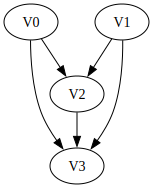

'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.


In [35]:
generator = AcyclicGraphGenerator('linear', npoints=25000, nodes=TOTAL_FEATURES)
data, graph = generator.generate()
#generator.to_csv('generated_graph')

dag = graphviz.Source(nx.nx_agraph.to_agraph(graph).to_string())
# dag.render('target_graph')
display(dag)

# split data
data_splits = np.array_split(data, NUM_CLIENTS)

selected_data_splits = []
for data_split in data_splits:
    drop_cols = list(np.random.choice(data_split.columns, TOTAL_FEATURES-FEATURES_PER_CLIENT, replace=False))
    selected_data_splits.append(data_split.drop(drop_cols, axis=1))
data_splits = selected_data_splits
del selected_data_splits

clients = {i:Client(data_split) for i,data_split in enumerate(data_splits)}

In [13]:
clients = {}


def get_sample_data(c, n, f):
    with (ro.default_converter + pandas2ri.converter).context():
        ro.r['source']('../scripts/example_data.r')
        get_example_data_f = ro.globalenv['get_example_data']

        result = get_example_data_f(c, n, f)
        
    return result

# TOTAL_FEATURES cant be set for this call right now, because the true graph is fixed
r = get_sample_data(NUM_CLIENTS, 10_000, FEATURES_PER_CLIENT)
for i,(_,v) in enumerate(r.items()):
    #v.to_csv(f'./test-data/data-{i}.csv')
    clients[i] = Client(v)

R[write to console]: 
Attache Paket: ‘igraph’


R[write to console]: Die folgenden Objekte sind maskiert von ‘package:stats’:

    decompose, spectrum


R[write to console]: Das folgende Objekt ist maskiert ‘package:base’:

    union


R[write to console]: Lade nötiges Paket: graph

R[write to console]: Lade nötiges Paket: BiocGenerics

R[write to console]: 
Attache Paket: ‘BiocGenerics’


R[write to console]: Die folgenden Objekte sind maskiert von ‘package:igraph’:

    normalize, path, union


R[write to console]: Die folgenden Objekte sind maskiert von ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: Die folgenden Objekte sind maskiert von ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames

## Server Run

In [14]:
server = Server(clients)

In [15]:
server.run_tests()

In [16]:
likelihood_ratio_tests = get_likelihood_tests(server.testing_engine.finished_rounds)
len(likelihood_ratio_tests)

15

In [17]:
# Sanity check obtained p values
p_vals = [l.p_val for l in likelihood_ratio_tests]
min(p_vals), max(p_vals)

(0.0, 0.35591723170632494)

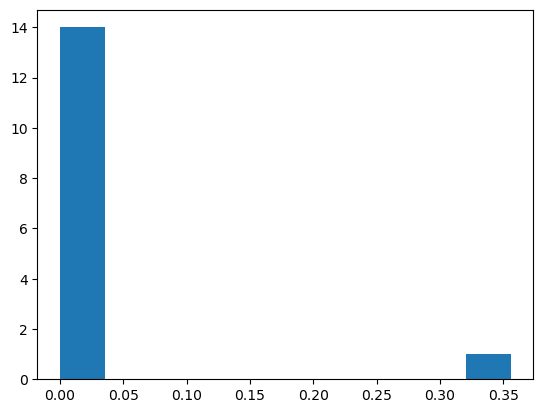

In [18]:
plt.hist(p_vals)
plt.show()

In [19]:
label2id_mapping = {l:i for i,l in enumerate(sorted(server.available_data), start=1)}

df = lrt2pandas(likelihood_ratio_tests, label2id_mapping)
df

,ord,X,Y,S,pvalue
1,0,1,2,,1.624798e-41
2,0,1,3,,5.020370e-163
3,0,1,4,,5.309358e-12
4,0,2,3,,9.675132e-100
5,0,2,4,,0.000000e+00
6,0,3,4,,0.000000e+00
7,1,1,2,3,1.579155e-162
8,1,1,2,4,0.000000e+00
9,1,1,3,2,2.802471e-112
10,1,1,3,4,0.000000e+00


In [20]:
labels = [str(v) for v in label2id_mapping.keys()]

pag, pag_labels = run_local_fci(df, labels)

[1] "W" "X" "Y" "Z"
[1] 4
Order=0; remaining edges:12
x= 1  y= 2  S=  : pval = 1.624798e-41 
x= 1  y= 3  S=  : pval = 5.02037e-163 
x= 1  y= 4  S=  : pval = 5.309358e-12 
x= 2  y= 1  S=  : pval = 1.624798e-41 
x= 2  y= 3  S=  : pval = 9.675132e-100 
x= 2  y= 4  S=  : pval = 0 
x= 3  y= 1  S=  : pval = 5.02037e-163 
x= 3  y= 2  S=  : pval = 9.675132e-100 
x= 3  y= 4  S=  : pval = 0 
x= 4  y= 1  S=  : pval = 5.309358e-12 
x= 4  y= 2  S=  : pval = 0 
x= 4  y= 3  S=  : pval = 0 
Order=1; remaining edges:12
x= 1  y= 2  S= 3 : pval = 1.579155e-162 
x= 1  y= 2  S= 4 : pval = 0 
x= 1  y= 3  S= 2 : pval = 2.802471e-112 
x= 1  y= 3  S= 4 : pval = 0 
x= 1  y= 4  S= 2 : pval = 0 
x= 1  y= 4  S= 3 : pval = 0 
x= 2  y= 1  S= 3 : pval = 1.579155e-162 
x= 2  y= 1  S= 4 : pval = 0 
x= 2  y= 3  S= 1 : pval = 2.974602e-175 
x= 2  y= 3  S= 4 : pval = NA 
x= 2  y= 4  S= 1 : pval = 0.3559172 
x= 3  y= 1  S= 2 : pval = 2.802471e-112 
x= 3  y= 1  S= 4 : pval = 0 
x= 3  y= 2  S= 1 : pval = 2.974602e-175 
x= 3 

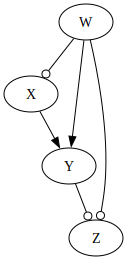

In [21]:
data2graph(pag, pag_labels)

## Results

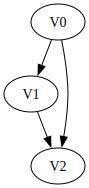

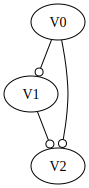

In [38]:
display(dag)
display(data2graph(pag, pag_labels))

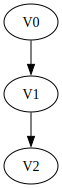

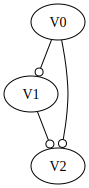

In [36]:
display(dag)
display(data2graph(pag, pag_labels))

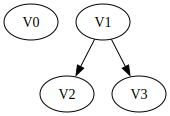

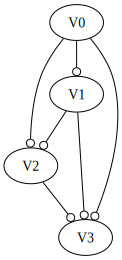

In [78]:
display(dag)
display(data2graph(pag, pag_labels))

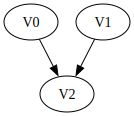

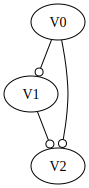

In [43]:
display(dag)
display(data2graph(pag, pag_labels))

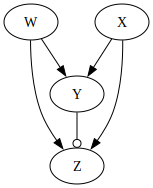

In [33]:
#display(dag)
# FROM example.r data
display(data2graph(pag, pag_labels))

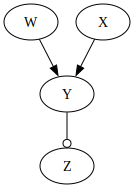

In [28]:
# attempt 2
data2graph(pag, pag_labels)